## Graph model selection outputs

In [308]:
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt

run = "base_strongaug_ema_inf_sq" #"mt_inf_sq" , "aldi_inf_udd" "base_strongaug_ema_inf_sq"
outputs_filename = f"/home/heather/GitHub/aldi0107/outputs/urchininf/{run}/model_selection/model_selection.json"
df = pd.read_json(outputs_filename)  # or however you load your DataFrame
# Create relplot
df['model_shortname'] = df['model'].apply(lambda x: x[-17:-4])
df['domain'] = df['source'].apply(lambda x: "source" if x else "target")
df['dataset_og'] = df['dataset'].apply(lambda x: x[4:-14])

df = df[df['model_shortname'] != "I/model_final"]


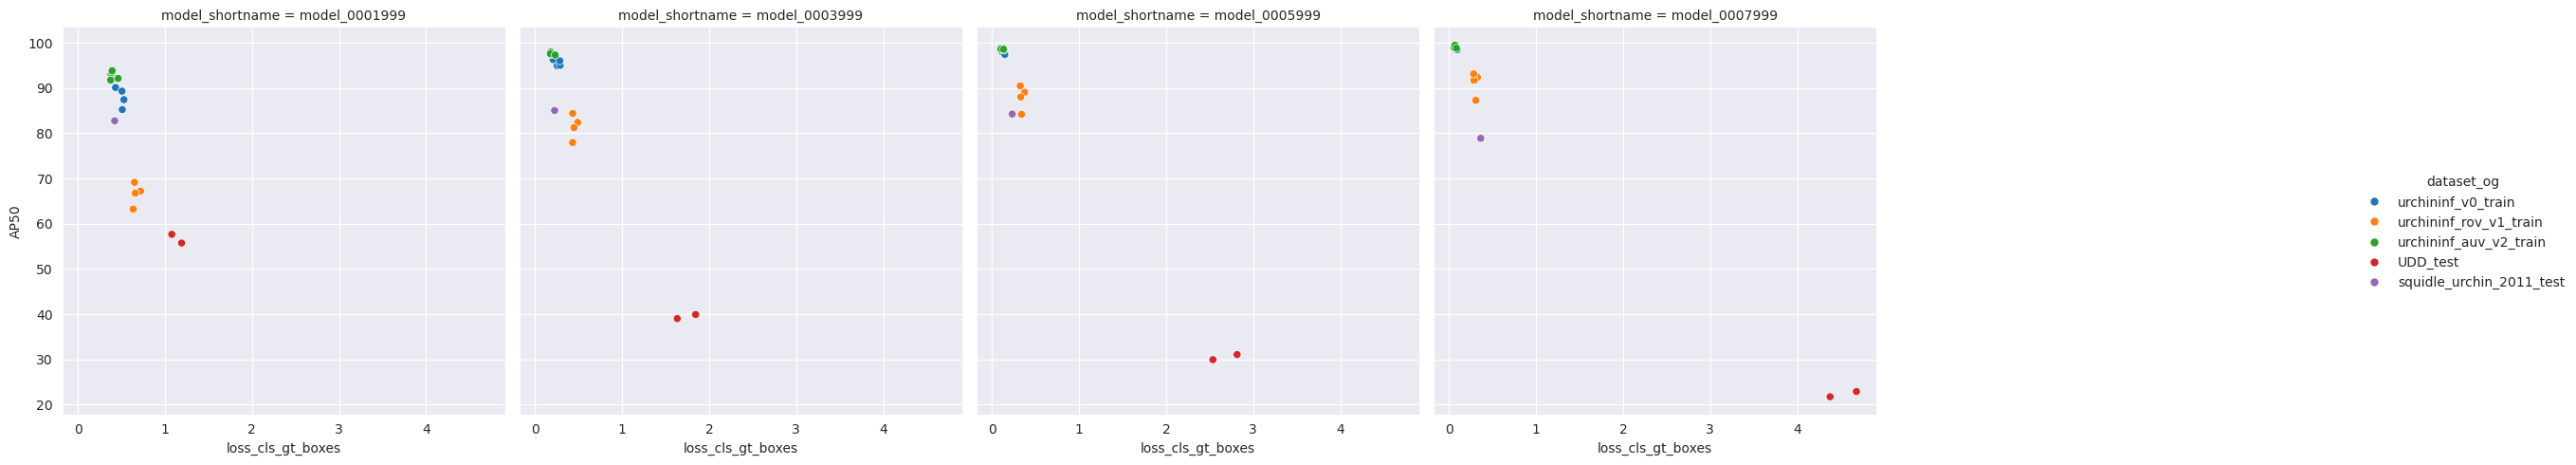

In [309]:

factors =  ['loss_cls_gt_boxes', 'loss_box_giou', 'loss_box_smooth_l1', 'loss_box_perturbed', ]
factor = factors[0]
eval = 'AP50'
    
sns.relplot(data=df, x=factor, y=eval, hue='dataset_og', col='model_shortname', kind='scatter', col_wrap=5)



# Show plot
plt.show()

In [310]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


eval_calc = f"{eval}_calc"
df[eval_calc] = 0.0
model_names = sorted(list(set(df['model_shortname'])))
for m in model_names:
    model = LinearRegression()
    model_src_data = df.loc[(df['model_shortname']==m) & df['source']]
    if len(model_src_data) > 0:
        # fit the model
        model.fit(model_src_data[[factor]], model_src_data[eval])

        # iterate through dataset
        for dataset in df[df['source']==False]['dataset_og'].unique():
            tgt_condition = (df['model_shortname']==m) & (df['source']==False) & (df['dataset_og']==dataset)
            model_tgt_data = df.loc[tgt_condition]
            out = list(model.predict(model_tgt_data[[factor]]))
            #print(f" out {out}")
            df.loc[tgt_condition, eval_calc] = out
            mean_eval = df.loc[tgt_condition][[eval]].mean().iloc[0]
            #print(df.loc[(df['model_shortname']==m) & (df['source'] == False)])
            mean_eval_calc = df.loc[tgt_condition][[eval_calc]].mean().iloc[0]
            print(f"Model {m} Dataset {dataset}--Actual {eval}: {mean_eval:.2f}, Predicted: {mean_eval_calc:.2f} Mean squared error: {mean_squared_error(out, model_tgt_data[[eval]]):.2f}")
        

Model model_0001999 Dataset UDD_test--Actual AP50: 56.67, Predicted: 25.22 Mean squared error: 1007.51
Model model_0001999 Dataset squidle_urchin_2011_test--Actual AP50: 82.75, Predicted: 91.48 Mean squared error: 76.31
Model model_0003999 Dataset UDD_test--Actual AP50: 39.44, Predicted: 4.29 Mean squared error: 1283.02
Model model_0003999 Dataset squidle_urchin_2011_test--Actual AP50: 85.02, Predicted: 96.06 Mean squared error: 121.96
Model model_0005999 Dataset UDD_test--Actual AP50: 30.47, Predicted: -18.48 Mean squared error: 2443.64
Model model_0005999 Dataset squidle_urchin_2011_test--Actual AP50: 84.24, Predicted: 93.06 Mean squared error: 77.92
Model model_0007999 Dataset UDD_test--Actual AP50: 22.29, Predicted: -52.04 Mean squared error: 5556.66
Model model_0007999 Dataset squidle_urchin_2011_test--Actual AP50: 78.87, Predicted: 88.99 Mean squared error: 102.51


#### Summary results


In [311]:
tgt_df = df.loc[df['source']==False]
tgt_df_by_dataset = tgt_df.groupby('dataset_og')

# Iterate through groups
print(f"Eval measure {eval}, prediction factor {factor}")
for dataset, group_df in tgt_df_by_dataset:
    # Group by other columns and calculate the mean of 'AP'
    dataset_summary_df = group_df.groupby(['model_shortname'], as_index=False)[[eval, eval_calc]].mean()
    max_index = dataset_summary_df[eval].idxmax()
    max_eval = dataset_summary_df[eval][max_index]
    min_index = dataset_summary_df[eval].idxmin()
    min_eval = dataset_summary_df[eval][min_index]
    sorted_models = dataset_summary_df['model_shortname'].sort_values(ascending=True)
    last_eval = dataset_summary_df.loc[(dataset_summary_df['model_shortname']==(sorted_models.iloc[-1]))]
    last_eval = last_eval[[eval]].iloc[0,0]
    best_calc_idx = dataset_summary_df[eval_calc].idxmax()
    best_calc = dataset_summary_df[eval][best_calc_idx]
    print(f"Dataset: {dataset}, Diff Best: {best_calc-max_eval:.2f}, Diff Last: {best_calc-last_eval:.2f}, Selected {eval}: {best_calc:.2f}, Max {eval}: {max_eval:.2f}, Last {eval}: {last_eval:.2f}, Worst: {min_eval:.2f}")


Eval measure AP50, prediction factor loss_cls_gt_boxes
Dataset: UDD_test, Diff Best: 0.00, Diff Last: 34.38, Selected AP50: 56.67, Max AP50: 56.67, Last AP50: 22.29, Worst: 22.29
Dataset: squidle_urchin_2011_test, Diff Best: 0.00, Diff Last: 6.15, Selected AP50: 85.02, Max AP50: 85.02, Last AP50: 78.87, Worst: 78.87


In [312]:
#sns.lmplot(data=df, x=factor, y=eval_calc, hue='domain', col='model_shortname')
results_df = df[['domain', eval, factor, 'model_shortname', 'dataset_og']].copy()
results_df['GT'] = 'Yes'

predict_df = df.loc[df['domain']=='target',['domain', eval_calc, factor, 'model_shortname', 'dataset_og']].copy()
predict_df['GT'] = 'No'
predict_df.columns = results_df.columns


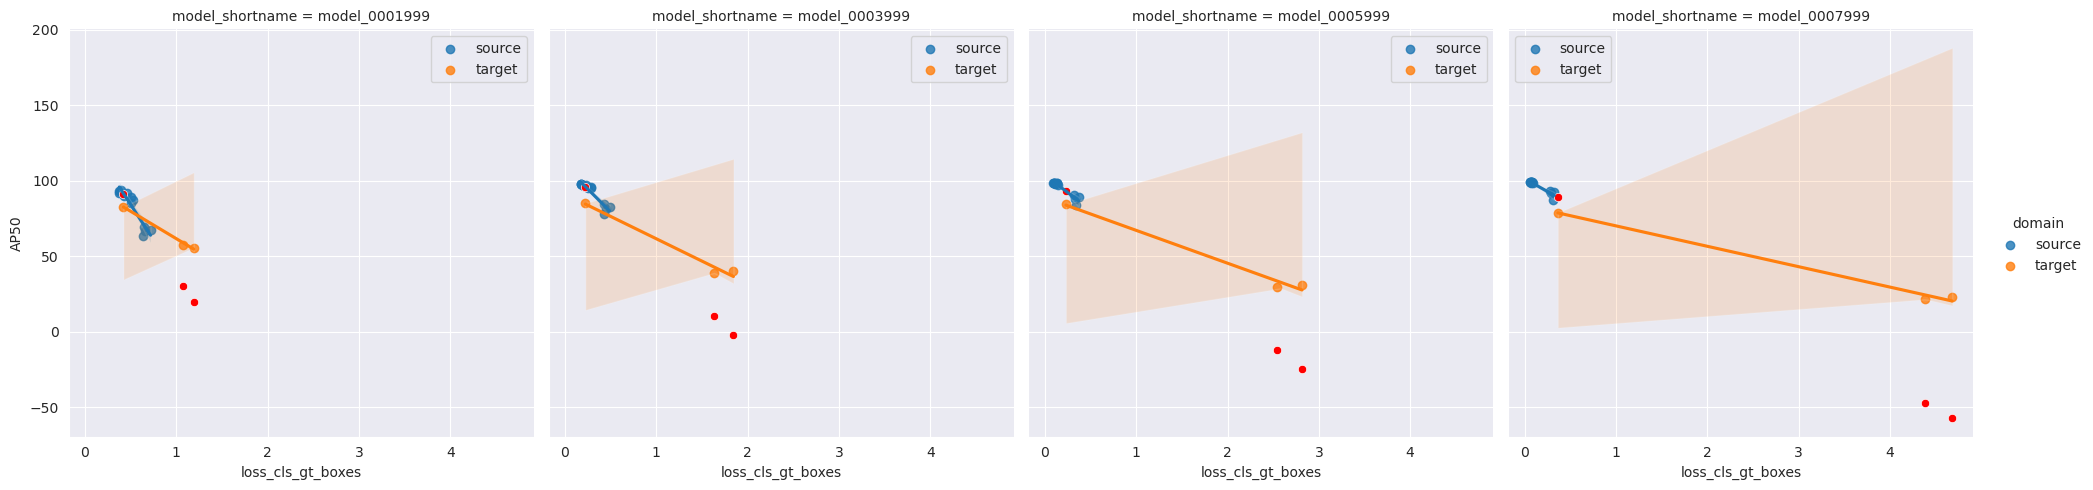

In [313]:
summary_df = pd.concat([results_df, predict_df], ignore_index=True)
# Create a FacetGrid
g = sns.lmplot(data=results_df, x=factor, y=eval, hue='domain', col='model_shortname', col_wrap=4)

# Add scatter plot and linear regression line to each facet
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the region
    mod_name = ax.get_title().split(' = ')[1]
    
    # select the data for the region
    data = predict_df[predict_df.model_shortname.eq(mod_name)]
    data = data[(data['domain']=='target') & (data['GT'] == 'No')]
    sns.scatterplot(data=data, x=factor, y=eval, ax=ax, color='red')
